# Data Exploration: Check the 2013 calculation to see how close this is with 2011 lcov

In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

RANDOM_SEED = 3201

In [2]:
# import data
df = pd.read_csv('../../data/processed/grid/bal/2018-04-04/bal_data.csv')

# Describe

In [3]:
df.head()

,Unnamed: 0,x,y,cId,area,city,lst_day_mean_mean,lst_day_mean_max,lst_day_mean_min,lst_night_mean_mean,...,imp_min_sl,tr_day_mean_sl,tr_day_max_sl,tr_day_min_sl,tr_nght_mean_sl,tr_nght_max_sl,tr_nght_min_sl,tr_2013_day_mean_sl,tr_2013_day_max_sl,tr_2013_day_min_sl
0,g1,424996.178971,189212.211496,1,140184.769096,bal,43.367470,46.500084,32.023964,28.524205,...,21.0,9.915928,10.121908,9.663185,8.294518,8.390340,8.240544,9.518347,9.784647,9.278713
1,g2,425496.178971,189212.211496,2,193761.065187,bal,42.892341,43.946873,32.320313,28.445516,...,21.0,9.863269,10.146366,9.598738,8.283910,8.359338,8.217494,9.466226,9.786129,9.211767
2,g3,425996.178971,189212.211496,3,193668.023016,bal,42.943431,45.691372,32.593929,28.362636,...,21.0,9.804301,10.031529,9.500826,8.282700,8.349176,8.226443,9.379036,9.604288,9.137661
3,g4,426496.178971,189212.211496,4,196080.635845,bal,44.308076,46.172302,31.623096,28.912349,...,21.0,9.704975,10.005294,9.408399,8.278716,8.328762,8.227140,9.299479,9.540898,9.085006
4,g5,426996.178971,189212.211496,5,195121.646444,bal,41.612921,45.883125,30.076824,27.828888,...,21.0,9.745549,9.998587,9.447186,8.276913,8.329207,8.221004,9.318212,9.532573,9.082112


In [4]:
# list of the variables
vars_all = df.columns.values
vars_all

array(['Unnamed: 0', 'x', 'y', 'cId', 'area', 'city', 'lst_day_mean_mean',
       'lst_day_mean_max', 'lst_day_mean_min', 'lst_night_mean_mean',
       'lst_night_mean_max', 'lst_night_mean_min', 'alb_mean_mean',
       'alb_mean_max', 'alb_mean_min', 'ndvi_mean_mean', 'ndvi_mean_max',
       'ndvi_mean_min', 'lcov_11', 'lcov_21', 'lcov_22', 'lcov_23',
       'lcov_24', 'lcov_31', 'lcov_41', 'lcov_42', 'lcov_43', 'lcov_52',
       'lcov_71', 'lcov_90', 'lcov_95', 'tree_mean', 'tree_max',
       'tree_min', 'imp_mean', 'imp_max', 'imp_min', 'tr_day_mean',
       'tr_day_max', 'tr_day_min', 'tr_nght_mean', 'tr_nght_max',
       'tr_nght_min', 'tr_2013_day_mean', 'tr_2013_day_max',
       'tr_2013_day_min', 'lst_day_mean_mean_sl', 'lst_day_mean_max_sl',
       'lst_day_mean_min_sl', 'lst_night_mean_mean_sl',
       'lst_night_mean_max_sl', 'lst_night_mean_min_sl',
       'alb_mean_mean_sl', 'alb_mean_max_sl', 'alb_mean_min_sl',
       'ndvi_mean_mean_sl', 'ndvi_mean_max_sl', 'ndvi_mean_mi

# Data manipulation

Remove the lat, long, name, cId columns and area == 0 rows

In [5]:
df = df.drop(['Unnamed: 0', 'x', 'y', 'cId'], axis = 1)

I'm going to make the land cover variables a percentage , rather than the total m2.

In [6]:
# list of the variables
vars_all = df.columns.values
# which columns have an lcov values in them?
vars_lcov = [i for i in vars_all if 'lcov' in i]
area_max = np.max([np.max(df[i]) for i in vars_lcov])
# print(area_max)
# describe
df[vars_lcov].describe()
# divide these values by the area value
df = df[df['area'] > 0]
for var_lcov in vars_lcov:
    df[var_lcov] = df[var_lcov]/area_max
# describe
# df[vars_lcov].describe()

## Response

In [7]:
lst_mean = df[['lst_day_mean_mean','lst_night_mean_mean', 'lst_day_mean_min', 'lst_day_mean_max', 'lst_night_mean_min', 'lst_night_mean_max']]
lst_vars = ['lst_day_mean_mean','lst_night_mean_mean', 'lst_day_mean_min', 'lst_day_mean_max', 'lst_night_mean_min', 'lst_night_mean_max']
lst_vars_sl = [var + '_sl' for var in lst_vars]
df = df.drop(lst_vars, axis=1)
df = df.drop(lst_vars_sl, axis=1)

# drop additional thermal radiance variables
thermrad_vars = ['tr_day_mean','tr_nght_mean', 'tr_day_min', 'tr_nght_min', 'tr_day_max', 'tr_nght_max']
thermrad_mean = df[thermrad_vars]

thermrad_vars_sl = [var + '_sl' for var in thermrad_vars]
df = df.drop(thermrad_vars, axis=1)
df = df.drop(thermrad_vars_sl, axis=1)

# thermal radiance for 2013
tr_2013_mean = df['tr_2013_day_mean']
tr_2013 = [s for s in df.columns.values if 'tr_2013' in s]
df = df.drop(tr_2013, axis=1)

In [8]:
df.count()

area                 1004
city                 1004
alb_mean_mean        1004
alb_mean_max         1004
alb_mean_min         1004
ndvi_mean_mean       1004
ndvi_mean_max        1004
ndvi_mean_min        1004
lcov_11              1004
lcov_21              1004
lcov_22              1004
lcov_23              1004
lcov_24              1004
lcov_31              1004
lcov_41              1004
lcov_42              1004
lcov_43              1004
lcov_52              1004
lcov_71              1004
lcov_90              1004
lcov_95              1004
tree_mean            1004
tree_max             1004
tree_min             1004
imp_mean             1004
imp_max              1004
imp_min              1004
alb_mean_mean_sl     1004
alb_mean_max_sl      1004
alb_mean_min_sl      1004
ndvi_mean_mean_sl    1004
ndvi_mean_max_sl     1004
ndvi_mean_min_sl     1004
lcov_11_sl           1004
lcov_21_sl           1004
lcov_22_sl           1004
lcov_23_sl           1004
lcov_24_sl           1004
lcov_31_sl  

# Divide into test and train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df, tr_2013_mean, test_size=0.2, random_state=RANDOM_SEED)

## Scale the variables

In [10]:
X_train = X_train.drop('city', axis=1)
X_test = X_test.drop('city', axis=1)
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(data = X_scaled, columns = X_train.columns.values)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns.values)

In [11]:
# make a copy
train = pd.concat([y_train.copy(), X_train.copy()], axis=1)
# train  = train.drop(['tr_day_min', 'tr_day_max', 'tr_nght_min', 'tr_nght_max'], axis=1)
train_nospatlag = train[train.columns[0:27]]
train.head()


,tr_2013_day_mean,area,alb_mean_mean,alb_mean_max,alb_mean_min,ndvi_mean_mean,ndvi_mean_max,ndvi_mean_min,lcov_11,lcov_21,...,lcov_52_sl,lcov_71_sl,lcov_90_sl,lcov_95_sl,tree_mean_sl,tree_max_sl,tree_min_sl,imp_mean_sl,imp_max_sl,imp_min_sl
0,9.517511,1.0,0.309634,0.255148,0.271625,0.482016,0.890519,0.324989,0.000000,0.157676,...,0.000000,0.000000,0.000000,0.000000,0.505015,0.235897,0.921348,0.505015,0.235897,0.921348
1,9.418313,1.0,0.350615,0.509015,0.289128,0.550282,0.927214,0.285207,0.000000,0.257261,...,0.000000,0.000000,0.139394,0.000000,0.524528,0.543590,0.910112,0.524528,0.543590,0.910112
2,NaN,1.0,0.163405,0.084470,0.171358,0.778381,0.902305,0.681378,0.000000,0.331950,...,0.000000,0.000000,0.000000,0.000000,0.513682,0.300855,0.898876,0.513682,0.300855,0.898876
3,9.478670,1.0,0.164853,0.121185,0.106356,0.668817,0.898424,0.330417,0.000000,0.369295,...,0.705882,0.368421,0.036364,0.000000,0.754357,0.596581,0.898876,0.754357,0.596581,0.898876
4,9.335044,1.0,0.000000,0.000918,0.058159,0.043064,0.004088,0.085880,0.941176,0.000000,...,0.000000,0.000000,0.218182,0.166667,0.105401,0.444444,0.000000,0.105401,0.444444,0.000000


In [12]:
train.columns.values

array(['tr_2013_day_mean', 'area', 'alb_mean_mean', 'alb_mean_max',
       'alb_mean_min', 'ndvi_mean_mean', 'ndvi_mean_max', 'ndvi_mean_min',
       'lcov_11', 'lcov_21', 'lcov_22', 'lcov_23', 'lcov_24', 'lcov_31',
       'lcov_41', 'lcov_42', 'lcov_43', 'lcov_52', 'lcov_71', 'lcov_90',
       'lcov_95', 'tree_mean', 'tree_max', 'tree_min', 'imp_mean',
       'imp_max', 'imp_min', 'alb_mean_mean_sl', 'alb_mean_max_sl',
       'alb_mean_min_sl', 'ndvi_mean_mean_sl', 'ndvi_mean_max_sl',
       'ndvi_mean_min_sl', 'lcov_11_sl', 'lcov_21_sl', 'lcov_22_sl',
       'lcov_23_sl', 'lcov_24_sl', 'lcov_31_sl', 'lcov_41_sl',
       'lcov_42_sl', 'lcov_43_sl', 'lcov_52_sl', 'lcov_71_sl',
       'lcov_90_sl', 'lcov_95_sl', 'tree_mean_sl', 'tree_max_sl',
       'tree_min_sl', 'imp_mean_sl', 'imp_max_sl', 'imp_min_sl'],
      dtype=object)

# Explore correlations

## Response

In [13]:
corr_matrix = thermrad_mean.corr()
corr_matrix

,tr_day_mean,tr_nght_mean,tr_day_min,tr_nght_min,tr_day_max,tr_nght_max
tr_day_mean,1.000000,-0.352651,0.892559,-0.357004,0.869070,-0.257105
tr_nght_mean,-0.352651,1.000000,-0.317170,0.836304,-0.329564,0.937560
tr_day_min,0.892559,-0.317170,1.000000,-0.235519,0.675065,-0.294769
tr_nght_min,-0.357004,0.836304,-0.235519,1.000000,-0.458283,0.666104
tr_day_max,0.869070,-0.329564,0.675065,-0.458283,1.000000,-0.168872
tr_nght_max,-0.257105,0.937560,-0.294769,0.666104,-0.168872,1.000000


## All

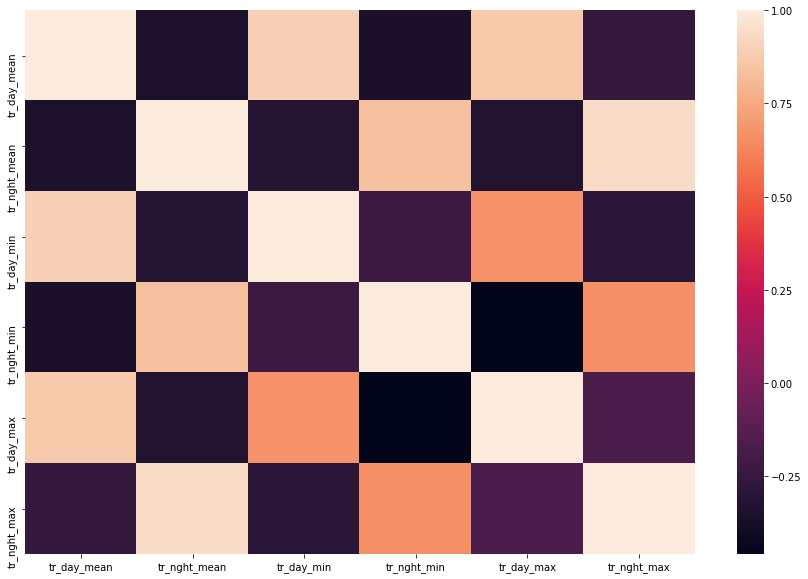

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

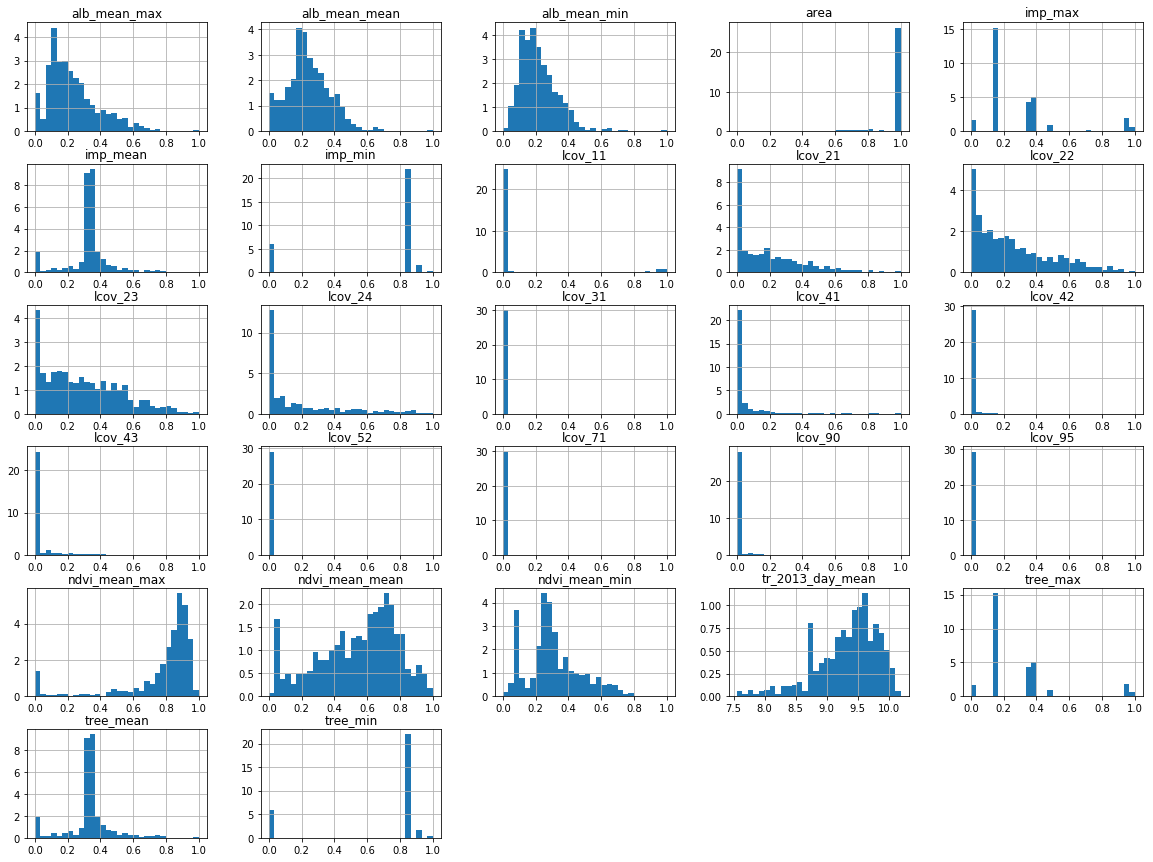

In [15]:
train_nospatlag.hist(bins = 30, figsize=(20,15), density = True)
plt.show()

In [16]:
corr_matrix = train_nospatlag.corr()
corr_matrix

,tr_2013_day_mean,area,alb_mean_mean,alb_mean_max,alb_mean_min,ndvi_mean_mean,ndvi_mean_max,ndvi_mean_min,lcov_11,lcov_21,...,lcov_52,lcov_71,lcov_90,lcov_95,tree_mean,tree_max,tree_min,imp_mean,imp_max,imp_min
tr_2013_day_mean,1.000000,-0.008264,-0.049679,-0.046039,-0.025488,-0.071254,-0.111525,-0.048606,0.104192,-0.022964,...,0.023482,0.016421,0.016849,0.065183,-0.055074,-0.003871,-0.082908,-0.055074,-0.003871,-0.082908
area,-0.008264,1.000000,0.038187,0.017984,0.038890,-0.132927,-0.104626,-0.053906,0.086283,-0.072823,...,-0.017159,0.001904,-0.196705,-0.216612,-0.139137,-0.167337,-0.073887,-0.139137,-0.167337,-0.073887
alb_mean_mean,-0.049679,0.038187,1.000000,0.756907,0.695688,-0.223350,0.131135,-0.241820,-0.474189,-0.385863,...,-0.139730,-0.053676,-0.080349,-0.106186,0.149792,-0.182077,0.319654,0.149792,-0.182077,0.319654
alb_mean_max,-0.046039,0.017984,0.756907,1.000000,0.350944,-0.218535,0.105093,-0.348428,-0.280988,-0.322363,...,-0.057433,-0.014344,-0.031292,-0.047268,0.119841,-0.081182,0.111559,0.119841,-0.081182,0.111559
alb_mean_min,-0.025488,0.038890,0.695688,0.350944,1.000000,-0.077791,0.063863,0.002041,-0.423866,-0.231135,...,-0.125712,-0.054184,-0.088523,-0.125352,0.122583,-0.258923,0.527277,0.122583,-0.258923,0.527277
ndvi_mean_mean,-0.071254,-0.132927,-0.223350,-0.218535,-0.077791,1.000000,0.788284,0.811331,-0.702762,0.744164,...,0.190417,0.066939,0.113837,-0.038868,0.713839,0.444619,0.617652,0.713839,0.444619,0.617652
ndvi_mean_max,-0.111525,-0.104626,0.131135,0.105093,0.063863,0.788284,1.000000,0.530525,-0.803679,0.483588,...,0.114380,0.041710,0.096407,0.040962,0.689089,0.435530,0.590977,0.689089,0.435530,0.590977
ndvi_mean_min,-0.048606,-0.053906,-0.241820,-0.348428,0.002041,0.811331,0.530525,1.000000,-0.532714,0.607321,...,0.158585,0.032366,0.011297,-0.127976,0.558345,0.270828,0.599321,0.558345,0.270828,0.599321
lcov_11,0.104192,0.086283,-0.474189,-0.280988,-0.423866,-0.702762,-0.803679,-0.532714,1.000000,-0.327003,...,-0.047479,-0.023337,-0.029538,0.097952,-0.757938,-0.237464,-0.782562,-0.757938,-0.237464,-0.782562
lcov_21,-0.022964,-0.072823,-0.385863,-0.322363,-0.231135,0.744164,0.483588,0.607321,-0.327003,1.000000,...,0.120499,0.031532,0.060209,0.012680,0.288757,0.381950,0.279684,0.288757,0.381950,0.279684


# Scatter

In [17]:
# list the covariates
covariates = list(train_nospatlag.columns)

## Response

## Response-covariate

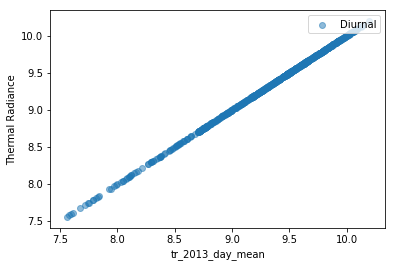

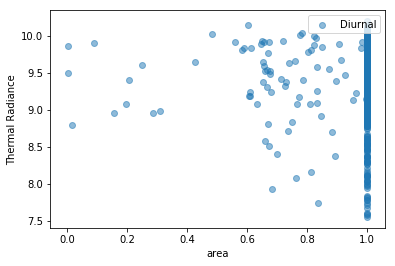

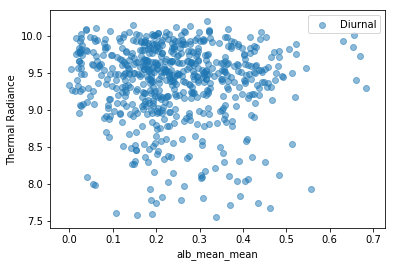

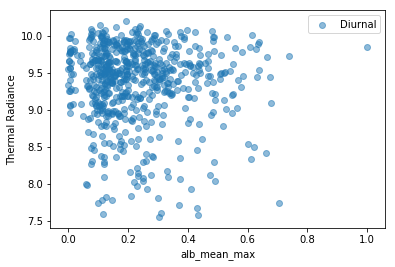

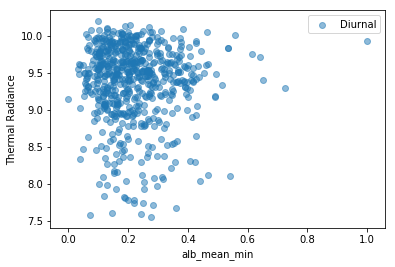

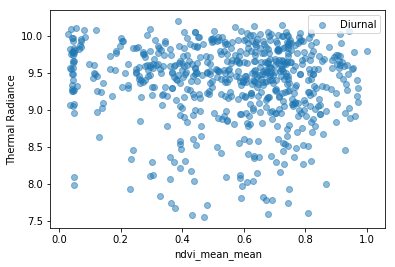

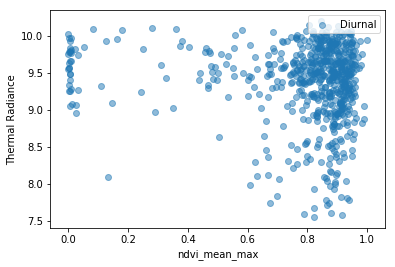

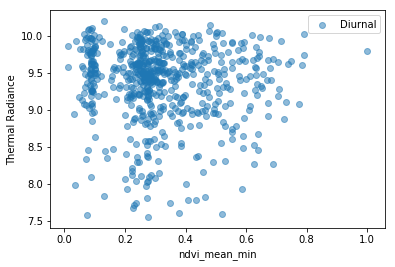

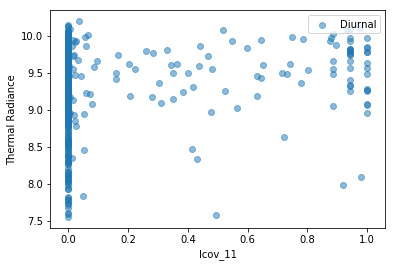

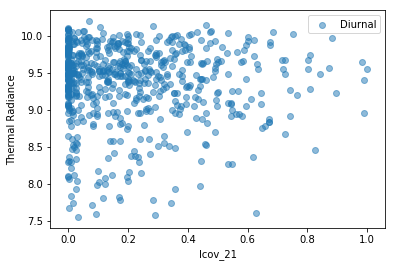

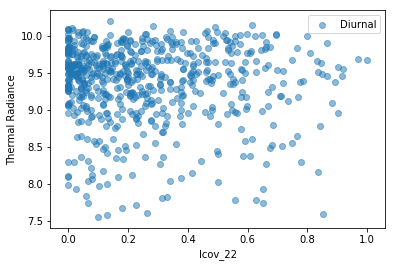

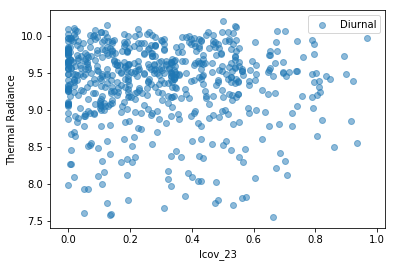

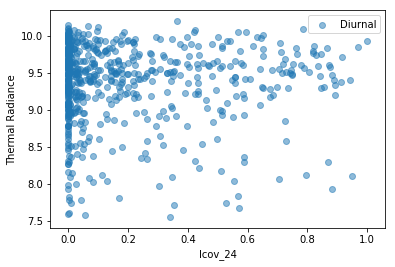

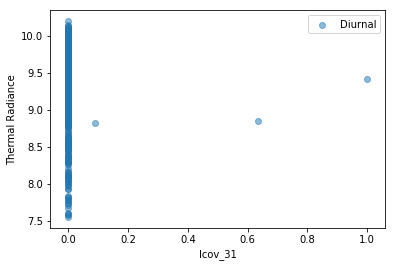

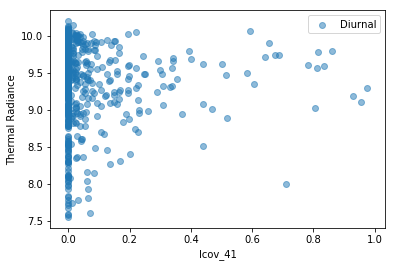

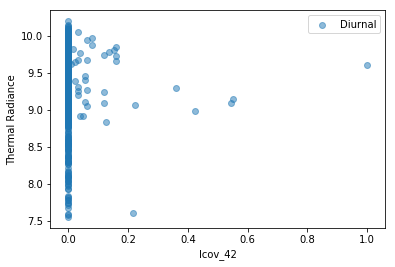

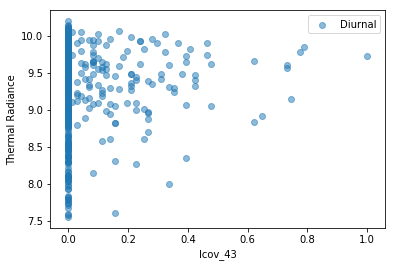

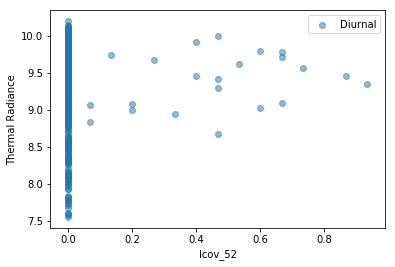

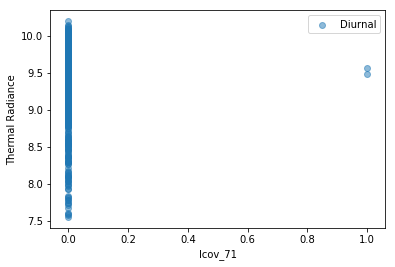

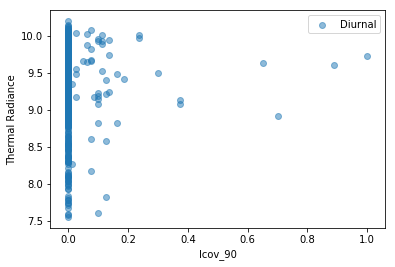

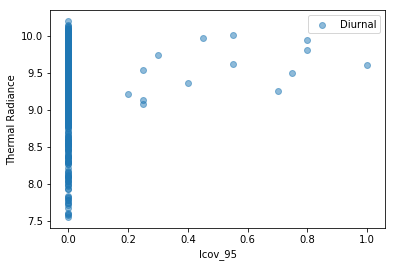

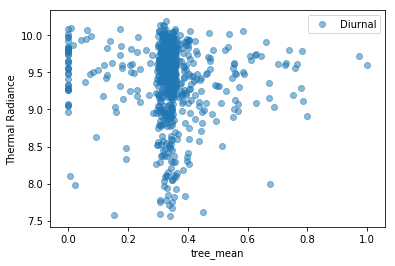

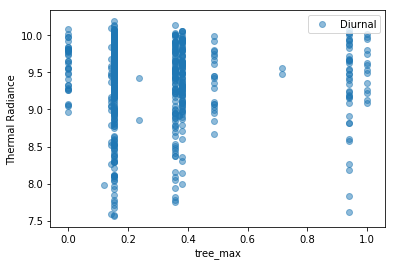

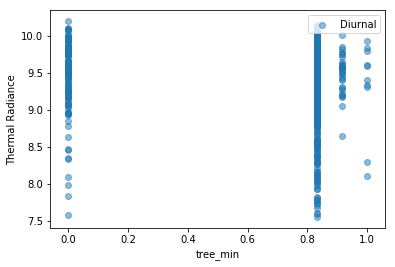

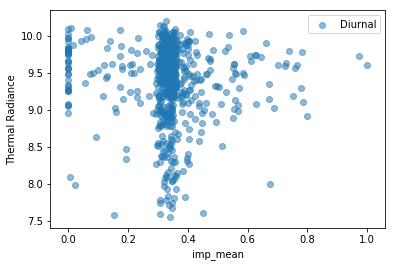

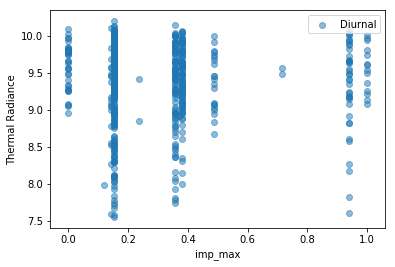

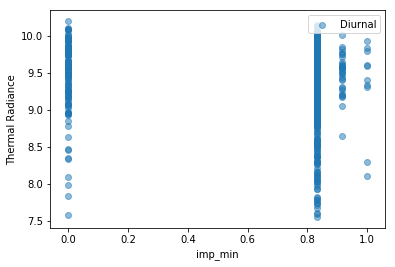

In [18]:

for covar in covariates:
    # plot each scatter
    plt.scatter(train[covar], train['tr_2013_day_mean'], label = 'Diurnal', alpha = 0.5)
#     plt.scatter(train[covar], train['tr_nght_mean'], label = 'Nocturnal', alpha = 0.5)
    plt.xlabel(covar)
    plt.ylabel('Thermal Radiance')
    plt.legend(loc='upper right')
    plt.show()
    
# Note: lcov variables are defined here: https://www.mrlc.gov/nlcd11_leg.php

# Initial Regressions

Doing some initial regression fitting to see how the models look and what the most important variables are.

In [20]:
# X_train, lst_day_train, lst_night_train, X_test
lst_day_train = y_train#['tr_2013_day_mean']
# lst_night_train = y_train['tr_nght_mean']
# test
lst_day_test = y_test#['tr_2013_day_mean']
# lst_night_test = y_test['tr_nght_mean']

### Null

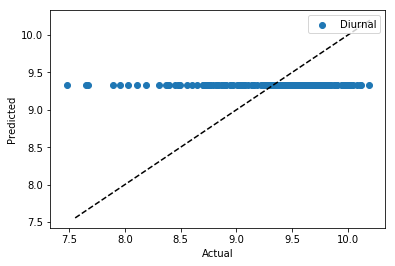

Diurnal 
 MAE: 0.3830 
 Out-of-bag R^2: -0.00


In [21]:
# train the model

# predict the model
null_predict_day = np.ones(len(lst_day_test)) * np.mean(lst_day_train)
# null_predict_night = np.ones(len(lst_night_test)) * np.mean(lst_night_train)

# plot predict vs actual
plt.scatter(lst_day_test, null_predict_day, label = 'Diurnal')
# plt.scatter(lst_night_test, null_predict_night, label = 'Nocturnal')
xy_line = (np.min(lst_day_train),np.max(lst_day_train))
plt.plot(xy_line,xy_line, 'k--')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(null_predict_day - lst_day_test))
# mae_night = np.mean(abs(null_predict_night - lst_night_test))
# print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_day_test, null_predict_day)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_day_test, null_predict_day)))

### Random Forest

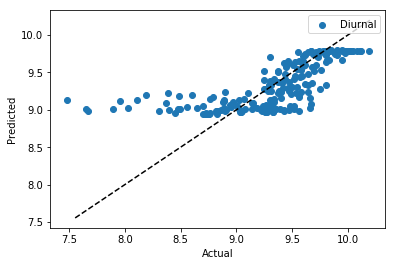

Diurnal 
 MAE: 0.2502 
 Out-of-bag R^2: 0.50


In [22]:
# train the model
rf_day_reg = RandomForestRegressor(max_depth=2, random_state=RANDOM_SEED, n_estimators=500, max_features=1/3)
# rf_night_reg = RandomForestRegressor(max_depth=2, random_state=RANDOM_SEED, n_estimators=500, max_features=1/3)
rf_day_reg.fit(X_train, lst_day_train)
# rf_night_reg.fit(X_train, lst_night_train)

# predict the model
rf_predict_day = rf_day_reg.predict(X_test)
# rf_predict_night = rf_night_reg.predict(X_test)

# plot predict vs actual
plt.scatter(lst_day_test, rf_predict_day, label = 'Diurnal')
# plt.scatter(lst_night_test, rf_predict_night, label = 'Nocturnal')
plt.plot(xy_line,xy_line, 'k--')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(rf_predict_day - lst_day_test))
# mae_night = np.mean(abs(rf_predict_night - lst_night_test))
# print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_day_test, rf_predict_day)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_day_test, rf_predict_day)))

#### Variable importance

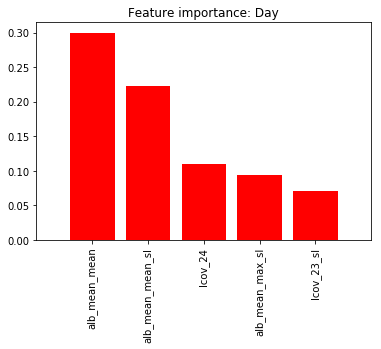

Feature ranking:
1. alb_mean_mean (0.2996759460633902)
2. alb_mean_mean_sl (0.22267270887093085)
3. lcov_24 (0.11003806751702562)
4. alb_mean_max_sl (0.09342056551795179)
5. lcov_23_sl (0.07100144110455739)
6. lcov_24_sl (0.051189172843205975)
7. lcov_23 (0.03904718875899445)
8. alb_mean_min_sl (0.022423433294152407)
9. alb_mean_max (0.013179320511450555)
10. lcov_22_sl (0.011774243127534395)
11. imp_mean (0.011064694450957945)
12. tree_mean (0.010344092923610125)
13. alb_mean_min (0.007818839939702317)
14. lcov_11 (0.007209961648094258)
15. ndvi_mean_mean (0.006281388490813907)
16. ndvi_mean_mean_sl (0.0037470313594690123)
17. lcov_22 (0.0036828674068151396)
18. imp_mean_sl (0.002605466821486827)
19. tree_mean_sl (0.0024670644248238334)
20. ndvi_mean_min (0.0023403925320267917)
21. tree_min_sl (0.0018461607712066664)
22. ndvi_mean_min_sl (0.0011893076478850918)
23. imp_min_sl (0.0011269774305738924)
24. lcov_21 (0.0009038148331512669)
25. lcov_11_sl (0.0008094817957136722)
26. lcov_21

In [23]:
important_num = 5 # top five
importances = rf_day_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Day")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="r", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. {} ({})".format(f + 1, covariates[indices[f]], importances[indices[f]]))



Note:
* lcov_11 is the area of water in the grid cell
* lcov_23 is the area of developed, medium intensity in the cell (single-family housing units)
* alb = albedo 
* tree = tree canopy
* imp = impervious surface
* the _mean / _min / _max are the mean, min, or max of measurements within the cell from the averaged satellite images
* _sl means the average of the surrounding cells (i.e. spatially lagged variable)



### Gradient Boosted Regression Trees

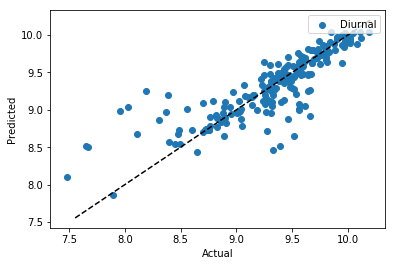

Diurnal 
 MAE: 0.1720 
 Out-of-bag R^2: 0.70


In [24]:
# train the model
gbm_day_reg = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
# gbm_night_reg = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
gbm_day_reg.fit(X_train, lst_day_train)
# gbm_night_reg.fit(X_train, lst_night_train)

# predict the model
gbm_predict_day = gbm_day_reg.predict(X_test)
# gbm_predict_night = gbm_night_reg.predict(X_test)

# plot predict vs actual
plt.scatter(lst_day_test, gbm_predict_day, label = 'Diurnal')
# plt.scatter(lst_night_test, gbm_predict_night, label = 'Nocturnal')
plt.plot(xy_line,xy_line, 'k--')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(gbm_predict_day - lst_day_test))
# mae_night = np.mean(abs(gbm_predict_night - lst_night_test))
# print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_night_test, gbm_predict_night)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_day_test, gbm_predict_day)))

In [ ]:
X_train.columns.values

### XGBoost

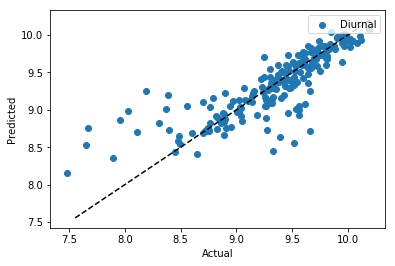

Diurnal 
 MAE: 0.1792 
 Out-of-bag R^2: 0.68


In [25]:
# train the model
xgb_day_reg = XGBRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
# xgb_night_reg = XGBRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
xgb_day_reg.fit(X_train, lst_day_train)
# xgb_night_reg.fit(X_train, lst_night_train)

# predict the model
xgb_predict_day = xgb_day_reg.predict(X_test)
# xgb_predict_night = xgb_night_reg.predict(X_test)

# plot predict vs actual
plt.scatter(lst_day_test, xgb_predict_day, label = 'Diurnal')
# plt.scatter(lst_night_test, xgb_predict_night, label = 'Nocturnal')
plt.plot(xy_line,xy_line, 'k--')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend(loc='upper right')
plt.show()

# calculate the MAE
mae_day = np.mean(abs(xgb_predict_day - lst_day_test))
# mae_night = np.mean(abs(xgb_predict_night - lst_night_test))
# print('Nocturnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_night, r2_score(lst_day_test, xgb_predict_day)))
print('Diurnal \n MAE: {:.4f} \n Out-of-bag R^2: {:.2f}'.format(mae_day, r2_score(lst_day_test, xgb_predict_day)))

### Variable Importance

In [ ]:
important_num = 5 # top five
importances = gbm_day_reg.feature_importances_
covariates = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance: Day")
plt.bar(range(important_num), importances[indices[0:important_num]],
       color="r", align="center")
plt.xticks(range(important_num), covariates[indices[0:important_num]], rotation=90)
plt.xlim([-1, important_num])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)): 
    print("{}. feature #{}: {} ({})".format(f + 1,indices[f], covariates[indices[f]], importances[indices[f]]))



Note:
* lcov_11 is the area of water in the grid cell
* lcov_22 is low-intensity development. usually 20-49% impervious surface, with single-family housing.

### Partial Dependence

In [ ]:
pdp_day = partial_dependence(gbm_day_reg, [1], X=X_train) 
# pdp_night = partial_dependence(gbm_night_reg, [1], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
# plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Mean Albedo')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pdp_day = partial_dependence(gbm_day_reg, [4], X=X_train) 
# pdp_night = partial_dependence(gbm_night_reg, [4], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
# plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Mean NDVI')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pdp_day = partial_dependence(gbm_day_reg, [7], X=X_train) 
# pdp_night = partial_dependence(gbm_night_reg, [7], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
# plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Area of water')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pdp_day = partial_dependence(gbm_day_reg, [20], X=X_train) 
# pdp_night = partial_dependence(gbm_night_reg, [20], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
# plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Tree canopy')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pdp_day = partial_dependence(gbm_day_reg, [23], X=X_train) 
# pdp_night = partial_dependence(gbm_night_reg, [23], X=X_train) 
# plt.plot(pdp_day[0], pdp_day[1], pdp_night[0], pdp_night[1])
%matplotlib inline
# plt.plot(pdp_night[1][0], pdp_night[0][0], label = 'night')
plt.plot(pdp_day[1][0], pdp_day[0][0], label = 'day')
plt.ylabel('Change in radiance')
plt.xlabel('Impervious surface')
plt.legend(loc='upper right')
plt.show()